# 04wk-1: 깊은신경망 (2) – 꺽인그래프의 한계(?), 시벤코정리, MNIST

최규빈  
2024-03-20

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/04wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [ ]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-y4BW27vnVa08AtMixu1IwL&si=v_BjoNGj2eVBht3Z >}}

# 2. Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fastai.data.all import *
import torchvision
import pathlib

# 3. 꺽인그래프의 한계?

`-` 걱정: 지난시간에 배운 기술은 sig를 취하기 전이 꺽은선인 형태만
가능할 듯 하다. 그래서 이 역시 표현력이 부족할 듯 하다.

`-` 그런데 생각보다 표현력이 풍부한 편이다. 즉 생각보다 쓸 만하다.

## A. Step은 표현 불가능하지 않나?

`-` 맞춰봐

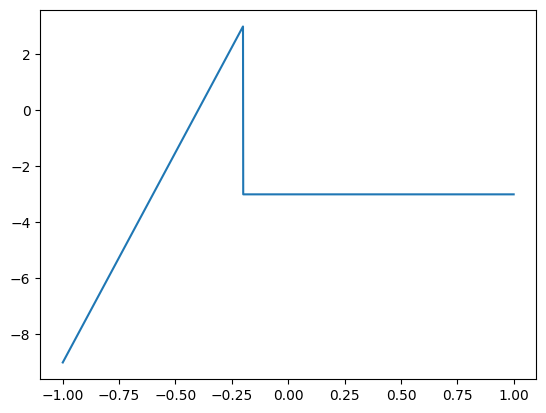

In [10]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(-1,1)
u = 0*x-3
u[x<-0.2] = (15*x+6)[x<-0.2]
#u[(-0.2<x)&(x<0.4)] = (0*x-1)[(-0.2<x)&(x<0.4)]


plt.plot(x,u)

In [ ]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(-1,1)
u = 0*x-3
u[x<-0.2] = (15*x+6)[x<-0.2]
u[(-0.2<x)&(x<0.4)] = (0*x-1)[(-0.2<x)&(x<0.4)]
sig = torch.nn.Sigmoid()
v = π = sig(u)
y = torch.bernoulli(v)

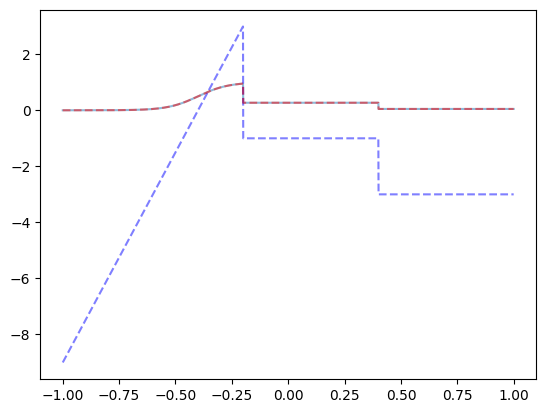

In [ ]:
plt.plot(x,sig(u),alpha = 0.5)
plt.plot(x,u,'--b',alpha = 0.5) #시그모이드 통과하기 전..
plt.plot(x,torch.nn.Sigmoid()(u),'--r',alpha = 0.5) #궁금증 해결 완료..

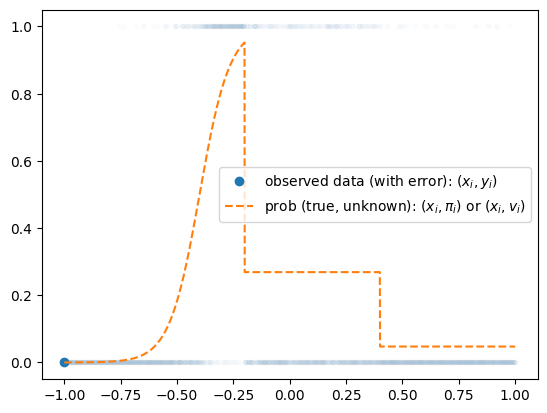

In [ ]:
#plt.plot(u,alpha=0.2)
plt.plot(x,y,'.',alpha=0.01,color="C0")
plt.plot(x[0],y[0],'o',color="C0",label=r"observed data (with error): $(x_i,y_i)$")
plt.plot(x,v,'--',label=r"prob (true, unknown): $(x_i,\pi_i)$ or $(x_i,v_i)$",color="C1") #시그모이드 취하기 전을 생각해볼 것..
plt.legend()

#아래로 팍 꺾인 선은... 기울기가 엄청 음수인 꺾은 선으로 대체하는것이 아이디어

`-` 저 주황색 구조를 어떻게 표현하지? $\to$ 선이 많이 꺾이면되는거아냐?

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

위에서 a1 = ReLU 함수 .. 256개를 꺾는다. \
a2 : 시그모이드 펑션


In [ ]:
#아래에서 시그모이드를 취하기 전과 비교하기 위해 시그모이드를 취하지 않는 학습을 진행(렐루의 선형변환 까지만 찾자)

#torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,256), #x를 선형변환 #꼭 256 아니어도 됨! 그냥 많이 직선을 만들어서 꺾겠다.
    torch.nn.ReLU(), #렐루를 256개
    torch.nn.Linear(256,1), #렐루 256개를 합침(선형 변환) 꺾인 직선들을 요약..
    #torch.nn.Sigmoid()
)
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.BCEWithLogitsLoss() #시그모이드를 취해서 BCE-loss를 구해주는 놈이던가? 맞음
optimizr = torch.optim.Adam(net.parameters()) #국민 옵티마이저.. 잘 모르면 그냥 얘임
#--#
for epoc in range(5000):
    ## 1
    uhat = net(x)
    ## 2
    loss = loss_fn(uhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

    #강의에선 얘만 적합하고 그냥 시그모이드 함수를 태워서 시각화 헀음

In [ ]:
#나는 시그모이드를 취한놈

#torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,256), #x를 선형변환 #꼭 256 아니어도 됨!
    torch.nn.ReLU(), #렐루를 256개
    torch.nn.Linear(256,1), #렐루 256개를 합침(선형 변환)
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
#loss_fn = torch.nn.BCEWithLogitsLoss() #시그모이드를 취해서 BCE- loss를 구해주는 놈이던가?
optimizr = torch.optim.Adam(net.parameters()) #국민 옵티마이저.. 잘 모르면 그냥 얘임
#--#
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'Fitted Prob vs real Prob')

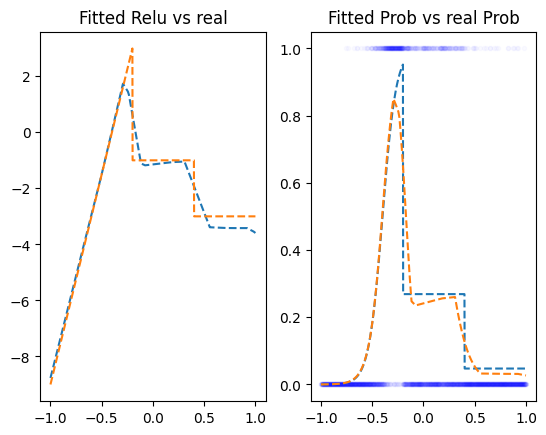

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(x,uhat.data, '--', label = 'before sigmoid')
ax[0].plot(x,u, '--', label = 'real_underline')
ax[0].set_title('Fitted Relu vs real')
ax[1].plot(x,y,'.',alpha=0.02,color="blue")
ax[1].plot(x,v, '--', label = 'real_underline -> sigmoid')
ax[1].plot(x,torch.nn.Sigmoid()(uhat.data), '--',label = 'fitted prob')
ax[1].set_title('Fitted Prob vs real Prob')
#그냥 내가 만들어본 곡선.. 아래껄 참조하길..

Text(0.5, 1.0, 'after sig')

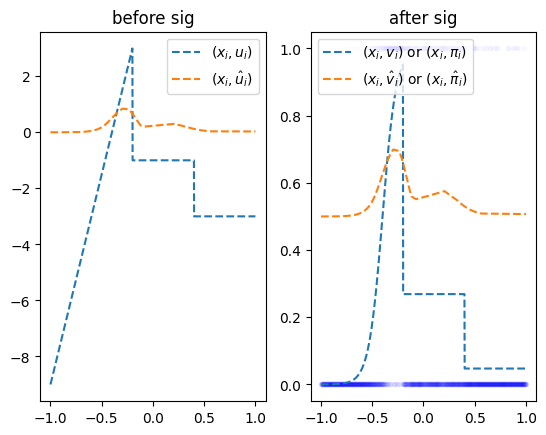

In [ ]:
#시그모이드가 취해진 상태라서 좀 불편하다..

fig,ax = plt.subplots(1,2)
ax[0].plot(x,u,'--',label=r"$(x_i,u_i)$")
ax[0].plot(x,yhat.data,'--',label=r"$(x_i,\hat{u}_i)$")
ax[0].legend()
ax[0].set_title("before sig")
ax[1].plot(x,y,'.',alpha=0.02,color="blue")
ax[1].plot(x,v,'--', color="C0", label=r"$(x_i,v_i)$ or $(x_i,\pi_i)$")
ax[1].plot(x,sig(yhat.data),'--',color="C1",label=r"$(x_i,\hat{v}_i)$ or $(x_i,\hat{\pi}_i)$")
ax[1].legend()
ax[1].set_title("after sig")

Text(0.5, 1.0, 'after sig')

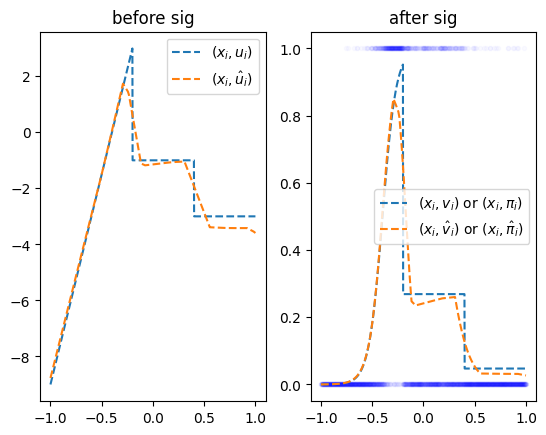

In [ ]:
#위의 그림을 적절히 (사실 yhat에서 uhat으로 바꾼것)

fig,ax = plt.subplots(1,2)
ax[0].plot(x,u,'--',label=r"$(x_i,u_i)$")
ax[0].plot(x,uhat.data,'--',label=r"$(x_i,\hat{u}_i)$")
ax[0].legend()
ax[0].set_title("before sig")
ax[1].plot(x,y,'.',alpha=0.02,color="blue")
ax[1].plot(x,v,'--', color="C0", label=r"$(x_i,v_i)$ or $(x_i,\pi_i)$")
ax[1].plot(x,sig(uhat.data),'--',color="C1",label=r"$(x_i,\hat{v}_i)$ or $(x_i,\hat{\pi}_i)$")
ax[1].legend()
ax[1].set_title("after sig")

## B. 곡선은 표현 불가능하지 않나?

`-` 맞춰봐[1]

$$y_i = e^{-x_i} \times  |\cos(5x_i)| \times \sin(5x) + \epsilon_i, \quad \epsilon_i \sim N(0,\sigma^2)$$

[1] 2024년 수능 미적30번 문제에 나온 함수응용

In [ ]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

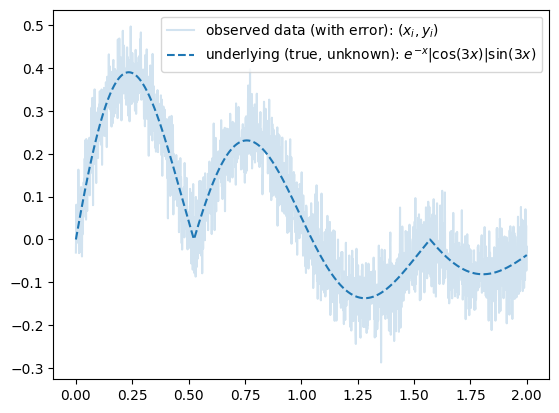

In [ ]:
plt.plot(x,y,label=r"observed data (with error): $(x_i,y_i)$", alpha=0.2)
plt.plot(x,fx,'--',color="C0",label=r"underlying (true, unknown): $e^{-x}|\cos(3x)|\sin(3x)$")
plt.legend()

`-` 맞춰본다..

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1024)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,1024)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [ ]:
#torch.manual_seed(43052)
#억지로 직선을 개많이 만들고 꺾어서 렐루를 많이 만듬 1024개
#그러고 꺾인 렐루들을 더해서 하나의 그래프를 만들어냄 (underlying을 추정)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(1000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

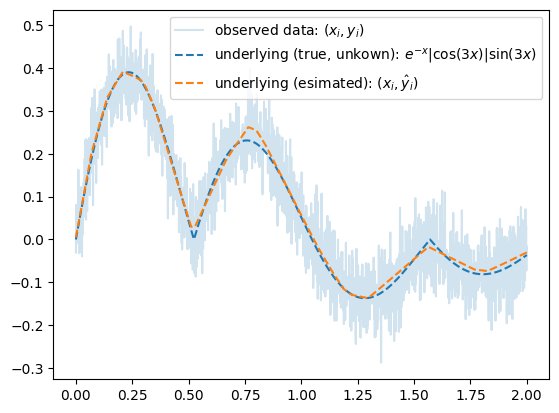

In [ ]:
plt.plot(x,y,label=r"observed data: $(x_i,y_i)$", alpha=0.2)
plt.plot(x,fx,'--',color="C0",label=r"underlying (true, unkown): $e^{-x}|\cos(3x)|\sin(3x)$")
plt.plot(x,yhat.data,'--',color="C1",label=r"underlying (esimated): $(x_i,\hat{y}_i)$")
plt.legend()

# 4. 시벤코정리

## A. 시벤코의 정리 소개

> **Universal Approximation Thm (Cybenko 1989)**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 continuous mapping
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 심층신경망(DNN)이 원하는 정확도로 근사시킨다는 의미이다. 예를들면
> 심층신경망은 아래와 같은 문제를 해결할 수 있다.
>
> -   ${\bf X}$는 토익점수, GPA, 공모전참가여부, ${\bf y}$는 취업여부일
>     경우 ${\bf X} \to {\bf y}$인 규칙을 심층신경망은 항상 찾을 수
>     있다.
> -   ${\bf X}$는 주택이미지, 지역정보, 주택면적, 주택에 대한 설명
>     ${\bf y}$는 주택가격일 경우 ${\bf X} \to {\bf y}$인 규칙을
>     심층신경망은 항상 찾을 수 있다.
>
> 즉 하나의 은닉층을 가진 심층신경망 모델의 표현력은 무한대라 볼 수
> 있다.

## B. 왜 가능한가?

`-` 데이터

In [ ]:
x = torch.linspace(-10,10,200).reshape(-1,1)

`-` 아래와 같은 네트워크를 고려하자. (스펙올라도 취업못하는 예제에서
썼던 네크워크랑 비슷해요)

In [ ]:
l1 = torch.nn.Linear(in_features=1,out_features=2)
a1 = torch.nn.Sigmoid() #렐루 안하고 그냥 시그모이드로 바로 꺾은 거임
l2 = torch.nn.Linear(in_features=2,out_features=1)

`-` 직관1: $l_1$,$l_2$의 가중치를 잘 결합하다보면 우연히 아래와 같이
만들 수 있다.

In [ ]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [ ]:
l2.weight.data = torch.tensor([[1.00,1.00]]) #높이 조정 가능 이건 꺾는거랑 관계 없음 꺾은걸 합칠 때 쓰임
l2.bias.data = torch.tensor([-1.00]) #out put 차원에 맞추는 것임..

#아래 3개의 그림을 보면 알 수 있겠지만, kernel을 만드는 것임.

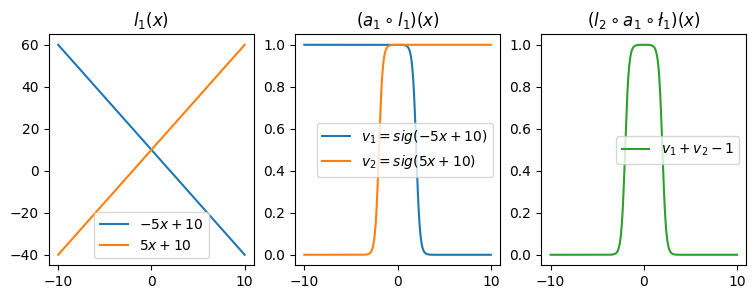

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x)[:,[0]].data,label=r"$-5x+10$")
ax[0].plot(x,l1(x)[:,[1]].data,label=r"$5x+10$")
ax[0].set_title('$l_1(x)$')
ax[0].legend()
ax[1].plot(x,a1(l1(x))[:,[0]].data,label=r"$v_1=sig(-5x+10)$")
ax[1].plot(x,a1(l1(x))[:,[1]].data,label=r"$v_2=sig(5x+10)$")
ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[1].legend()
ax[2].plot(x,l2(a1(l1(x))).data,color='C2',label=r"$v_1+v_2-1$")
ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')
ax[2].legend()

`-` 직관2: 아래들도 가능할듯?

(-0.1, 2.6)

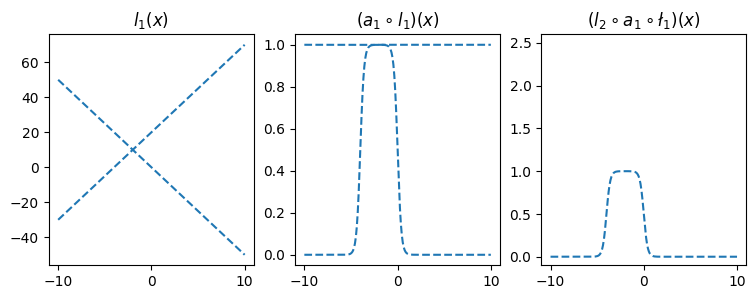

In [ ]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

(-0.1, 2.6)

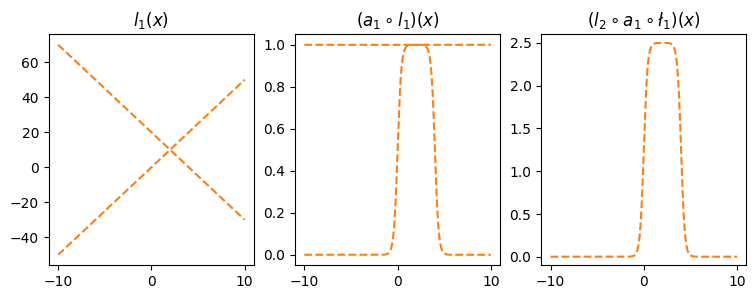

In [ ]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+00.00])
l2.weight.data = torch.tensor([[2.50,2.50]]) #꺾인걸 합칠떄의 가중치!
l2.bias.data = torch.tensor([-2.50])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

`-` 직관3: `은닉층의노드수=4`로 하고 적당한 가중치를 조정하면
$(l_2\circ a_1 \circ l_1)(x)$의 결과로 주황색선 + 파란색선도 가능할 것
같다. $\to$ 실제로 가능함

In [ ]:
l1 = torch.nn.Linear(in_features=1,out_features=4) #out put 4개
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [ ]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

Text(0.5, 1.0, '$(l_2 \\circ a_1 \\circ l_1)(x)$')

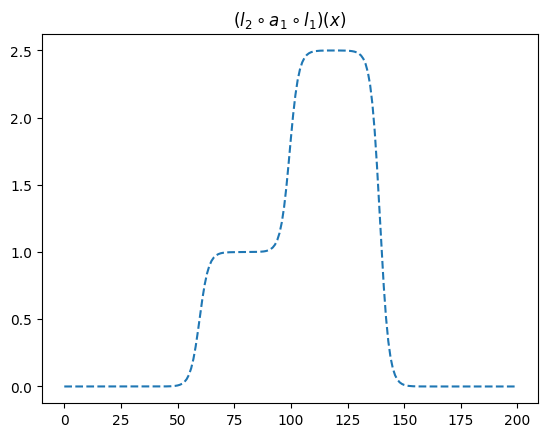

In [ ]:
plt.plot(l2(a1(l1(x))).data,'--') #네트워크 마렵다
plt.title(r"$(l_2 \circ a_1 \circ l_1)(x)$")

> 이러한 함수는 계단모양이며, 0을 제외한 서로다른 계단의 높이는 2개가
> 된다. 이를 간단히 “2단계-계단함수”라고 칭하자.

`-` 정리1: 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은
“1단계-계단함수” 함수 $h$를 만들 수 있다.

In [ ]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0 #팍 솟구치게 가중치를 조정한 것임
#시험에 람다 펑션을 활용하여 렐루를 만들게끔 할 것 같음.. 무조건 외울것!

Text(0.5, 1.0, '$h(x)$')

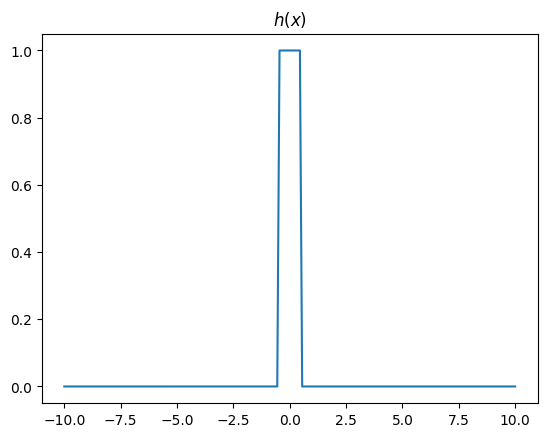

In [ ]:
plt.plot(x,h(x)) #각진 함수 같지만.. 사실은 곡선이다!
plt.title("$h(x)$")

`-` 정리2: 위와 같은 함수 $h$를 활성화함수로 하고 $m$개의 노드를 가지는
은닉층을 생각해보자. 이러한 은닉층을 사용한다면 “m단계-계단함수”와 같은
형태의 네트워크는 아래와 같이 $m$개의 은닉노드를 써서 항상 표현할 수
있다.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` 직관4: 그런데 어떠한 함수형태라도 구불구불한 “m단계-계단함수”로 다
근사할 수 있지 않나?

## C. $h$의 위력

`-` $h(x)$를 활성화함수로 가지는 네트워크를 설계하여 보자.

### 위의 수식은 무조건 이해하고 넘어가야 한다

첫 번쨰 수식은 강의 초반부에서 다루던 내용이고\
두 번째 수식은 직선 2개를 이용하여 하나의 커널을 만드는 기법이다.\
그래서 2m, 즉 2배의 직선이 더 필요한 것이다.

In [ ]:
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__()
    def forward(self, u): #재정의.. u를 받겠습니다.
        h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
        v = h(u)
        return v # activation 의 출력, v를 반환하겠습니다.

In [ ]:
import inspect

# Parent 클래스의 __init__ 메서드의 매개변수 정보를 확인
params = inspect.signature(torch.nn.Module.__init__).parameters
print(params)

OrderedDict([('self', <Parameter "self">), ('args', <Parameter "*args">), ('kwargs', <Parameter "**kwargs">)])


In [ ]:
a1 = MyActivation() #클래스에서 인스턴스 객체 생성
# a1 = torch.nn.Sigmoid(), a1 = torch.nn.ReLU() 대신에 a1 = MyActivation()

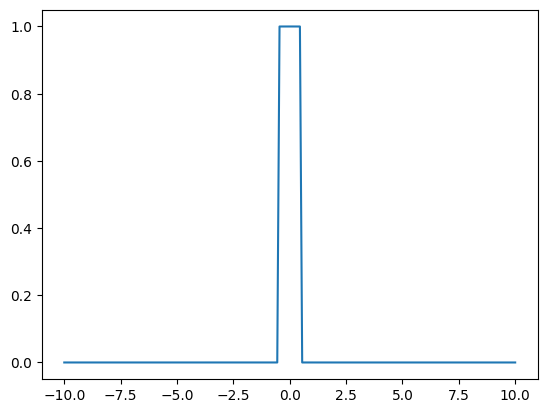

In [ ]:
plt.plot(x,a1(x))

`-` 아래와 같이 하나의 은닉층을 가지고 있더라도 많은 노드수만 보장되면
매우 충분한 표현력을 가짐

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` $h$의 위력

**예제1** – 스펙높아도 취업이 안된다고??

그냥 다 맞춘다.. by 시벤코 정리

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

In [ ]:
df

,x,prob,y
0,-1.000000,0.000045,0.0
1,-0.998999,0.000046,0.0
2,-0.997999,0.000047,0.0
3,-0.996998,0.000047,0.0
4,-0.995998,0.000048,0.0
...,...,...,...
1995,0.995998,0.505002,0.0
1996,0.996998,0.503752,0.0
1997,0.997999,0.502501,0.0
1998,0.998999,0.501251,1.0


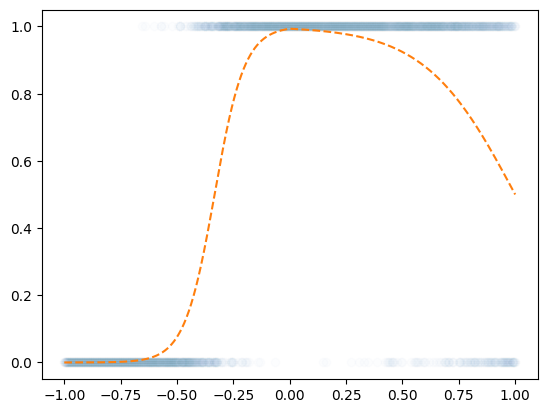

In [ ]:
plt.plot(x,y,'o',alpha = 0.01)
plt.plot(x,prob,'--')

In [ ]:
torch.manual_seed(43052)
# h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
# class MyActivation(torch.nn.Module):
#    def __init__(self):
#        super().__init__()
#    def forward(self, u):
#        v = h(u)
#        return v
# ---
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048), #메모리를 효율적으로 활용하기 위해 2의 power 를 사용한다고 한다. 1024개의 커널? ㅇㅇ
    MyActivation(), #우리가 만든 활성화 함수.. 인스턴스 뽑아서 해도 괜찮을듯.
    torch.nn.Linear(2048,1),
    torch.nn.Sigmoid() #0 1로 떨어지게 만들고 싶으므로.
)
loss_fn = torch.nn.BCELoss() #시그모이드 태웠으니까 그냥 BCELoss 사용
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(100):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

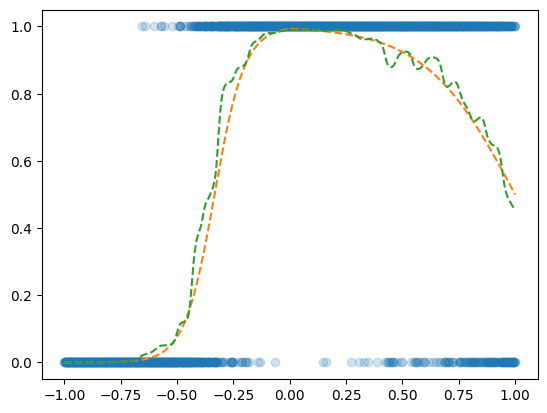

In [ ]:
plt.plot(x,y,'o',alpha=0.2)
plt.plot(x,prob,'--')
plt.plot(x,net(x).data,'--')

**예제2** – 수능에 나왔다던 이상한 곡선..?

In [ ]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

In [ ]:
# torch.manual_seed(43052)
# h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
# class MyActivation(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#     def forward(self, u):
#         v = h(u)
#         return v
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
)
loss_fn = torch.nn.MSELoss() #확률에 대한 언더라잉을 구하는게 아니니까 sigmoid도 안취해도 되고 MSE로스를 쓰는것이 적절할 것 같다.. !
#위와 같은 생각이 모델을 짤 때 능동적으로 들면 최고이긴 할텐데....
optimizr = torch.optim.Adam(net.parameters()) #국민 옵티마이저 아담..!
#---#
for epoc in range(100):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

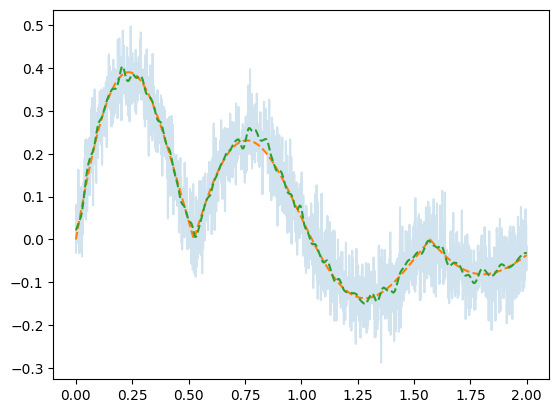

In [ ]:
plt.plot(x,y,alpha=0.2)
plt.plot(x,fx,'--')
plt.plot(x,net(x).data,'--')

## D. 의문점

`-` 이 수업을 잘 이해한 사람: 그냥 활성화함수를 $h$로 쓰면 끝 아니야?
뭐하러 relu 를 쓰는거지?

`-` 딥러닝을 좀 공부해본사람1: 왜 딥러닝이 2010년이 지나서야 떳지?
1989년에 세상의 모든 문제가 풀려야 하는것 아닌가?

`-` 딥러닝을 좀 공부해본사람2: 하나의 은닉층을 표현하는 네크워크는 잘
안쓰지 않나? 은닉층이 많을수록 좋다고 들었는데?

`-` 약간의 의구심이 있지만 아무튼 우리는 아래의 무기를 가진 꼴이 되었다.

> **우리의 무기**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크로,
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> $f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$ 인 모든 continuous
> mapping $f$ 을 원하는 정확도로 “근사”시킬 수 있다.

**스포일러... 위의 방식은 모델의 표현력이 너무 좋기 떄문에 overfitting issue가 있다.**

보이는가? **모~든 continuous mapping f**를 근사할 수 있다


# 5. MNIST 해결

## A. 데이터 다운로드

In [ ]:
untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')

Path('/root/.fastai/data/mnist_png')

In [ ]:
!ls '/root/.fastai/data/mnist_png'

testing  training


In [ ]:
!ls '/root/.fastai/data/mnist_png/training/'

0  1  2  3  4  5  6  7	8  9


In [ ]:
!ls '/root/.fastai/data/mnist_png/training/3' | head

10000.png
10011.png
10031.png
10034.png
10042.png
10052.png
10074.png
1007.png
10091.png
10093.png


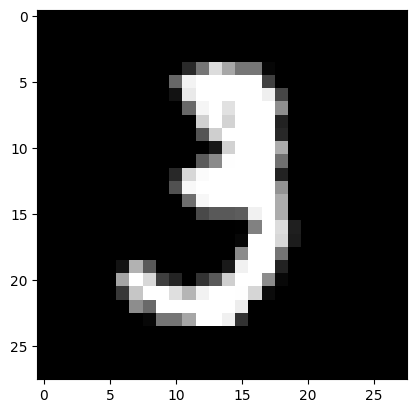

In [ ]:
img3 = torchvision.io.read_image('/root/.fastai/data/mnist_png/training/3/10.png') #이미지 자료를 읽어오는 명령 텐서형태로 저장됨.
plt.imshow(img3.reshape(28,28),cmap="gray") #리쉐잎을 해야 시각화 가능

In [ ]:
img3.shape #흑백 28행 28열 데이터

torch.Size([1, 28, 28])

In [ ]:
img3 #이미지로 변환하기 전엔 이런 꼴의 텐서이다!

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
          166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
          254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [ ]:
np.ones(24).reshape(2,3,4) #2겹, 3행, 4얄

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [ ]:
img3.shape

torch.Size([1, 28, 28])

## B. 예비학습 – \``plt.imshow()`

`-` `plt.imshow(...)` 에서 `...`이 shape이 (??,??)이면 흑백이미지를 출력

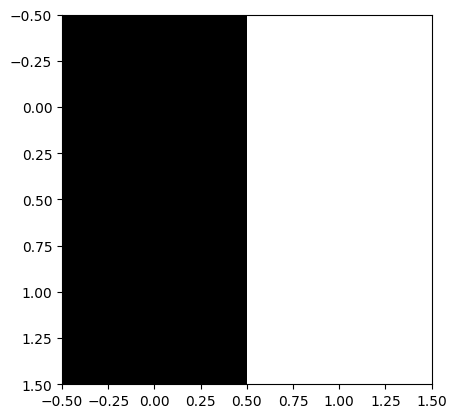

In [ ]:
plt.imshow([[0,255],[0,255]],cmap='gray')

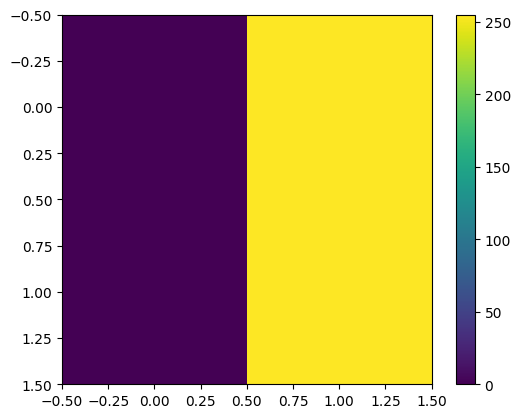

In [ ]:
plt.imshow([[0,255],
            [0,255]]) #사실 색이 아닌데 그냥 숫자를 색으로 입힌거임
plt.colorbar()
#shape에 따라 흑백이냐, 컬러냐 갈림.

`-` `plt.imshow(...)` 에서 `...`의 shape이 (??,??,3)이면 칼라이미지를
출력

In [ ]:
r = [[0,255],[0,255]]
g = [[255,0],[0,0]]
b = [[0,0],[255,255]] #격자 4개에 각 rgb의 수준을 넣는거임 !!
mat = np.stack([r,g,b],axis=-1)
mat.shape
#빛의 합성임.. 채도가 올라

(2, 2, 3)

In [ ]:
mat #허허..;

array([[[  0, 255,   0],
        [255,   0,   0]],

       [[  0,   0, 255],
        [255,   0, 255]]])

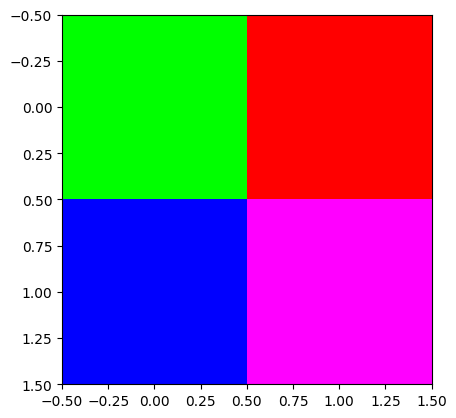

In [ ]:
plt.imshow(mat)

`-` `plt.imshow(...)` 에서 `...`의 자료형이 int인지 float인지에 따라서
인식이 다름

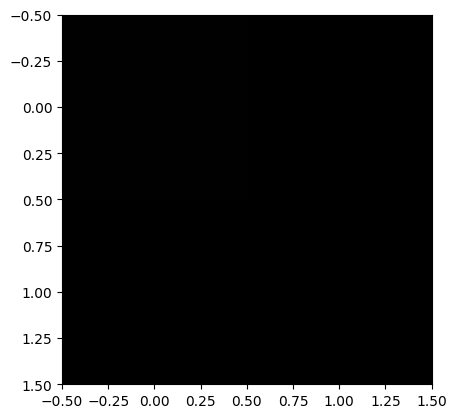

In [ ]:
r = [[0,1],[0,1]] #정수로 들어가면 색상을 1/255 만큼만 넣음
g = [[1,0],[0,0]]
b = [[0,0],[1,0]]
plt.imshow(np.stack([r,g,b],axis=-1))

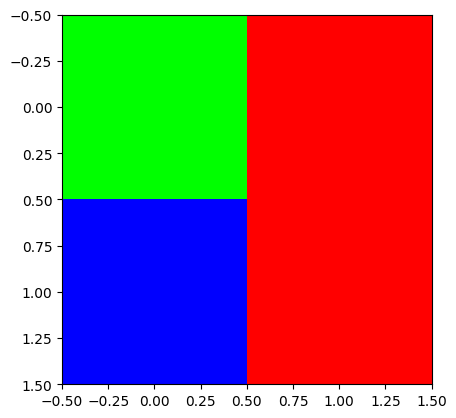

In [ ]:
r = [[0,1.0],[0,1.0]] #이게 플롯으로 들어가면 맥시멈이 1.0임 (비율)
g = [[1.0,0],[0,0]] #int형으로 들어가면 맥시멈이 255
b = [[0,0],[1.0,0]]
plt.imshow(np.stack([r,g,b],axis=-1))

## C. 예비학습 – pathlib

In [ ]:
import pathlib

`-` 오브젝트 생성

In [ ]:
path = pathlib.Path('.') #현재 디렉토리를 의미, 그리고 인스턴스 만드는 문법
path

Path('.')

`-` 기능1 – `.ls()`

In [ ]:
path.ls() #현재 디렉토리의 파일들

(#2) [Path('.config'),Path('sample_data')]

`-` 이미지 파일이 저장된 경로로 새로운 `path`오브젝트를 만들고 기능1
수행

In [ ]:
path = pathlib.Path('/root/.fastai/data/mnist_png')
path

Path('/root/.fastai/data/mnist_png')

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

`-` 기능2: `/` 로 새로운 path 생성하기

In [ ]:
(path / 'training') #일종의 연산자

Path('/root/.fastai/data/mnist_png/training')

`-` 기능1,2의 결합

In [ ]:
(path / 'training').ls()

(#10) [Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/1')]

## D. 데이터정리

`-` 데이터가 저장된 path 설정

In [ ]:
path = pathlib.Path('/root/.fastai/data/mnist_png')

`-` `X` ,`y`를 만듦

이거 자료 정리하는거 과정을 좀 알아야함... 밑에 한번 순차적으로 정리 해볼것

원래 [(1,28,28),(1,28,28), ... , (1,28,28)] 이렇게 중첩 리스트가 되어있는데, torch.stack(,axis = 0)을 활용하여 shape 가 (n,1,28,28) 인 텐서로 만든 것임.

In [ ]:
X3 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'training/3').ls()],axis=0) #(n,1,28,28) 겹으로 쌓고싶음
X7 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'training/7').ls()],axis=0)

In [ ]:
X3.shape, X7.shape

(torch.Size([6131, 1, 28, 28]), torch.Size([6265, 1, 28, 28]))

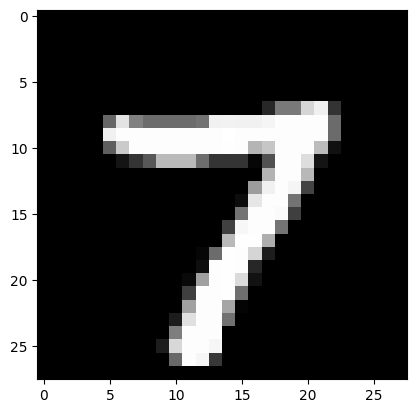

In [ ]:
plt.imshow(X7[0].reshape(28,28), cmap='gray') #ㅋㅋ; 영어공부해라..

In [ ]:
y = torch.tensor([0.0]*6131+[1.0]*6265).reshape(-1,1) #레이블 (참값).. 근데 float?

In [ ]:
X = torch.concat([X3,X7],axis=0) #데이터를 싹 붙임
X.shape

torch.Size([12396, 1, 28, 28])

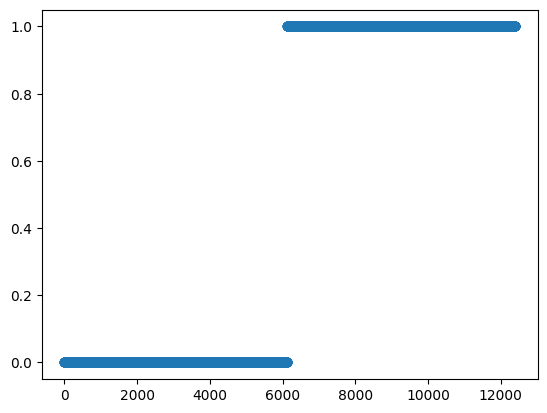

In [ ]:
plt.plot(y,'o')

-   “y=0.0” 은 숫자3을 의미함, “y=1.0” 은 숫자7을 의미함
-   숫자3은 6131개, 숫자7은 6265개 있음

`-` 우리는 ${\bf X}: (n,1,28,28)$ 에서 ${\bf y}: (n,1)$으로 가는 맵핑을
배우고 싶음. $\to$ 이런건 배운적이 없는데?.. $\to$ 그렇다면
${\bf X}:(n,784) \to {\bf y}:(n,1)$ 으로 가는 맵핑을 학습하자.

In [ ]:
Xnp = X.reshape(-1,28*28).float() #우리가 알고자 하는 setting으로 조정하는 reshaping
X.shape, Xnp.shape #자료형이 다 Float이어야함도 인지

(torch.Size([12396, 1, 28, 28]), torch.Size([12396, 784]))

## E. 학습

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(300):
    ## step1
    yhat = net(Xnp)
    ## step2
    loss = loss_fn(yhat,y)
    ## step3
    loss.backward()
    ## step4
    optimizr.step()
    optimizr.zero_grad()

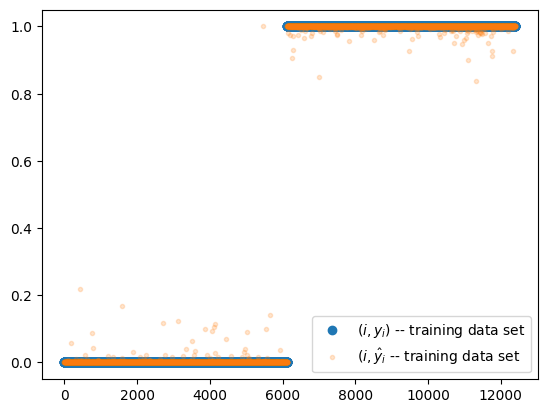

In [ ]:
plt.plot(y,'o',label=r"$(i,y_i)$ -- training data set")
plt.plot(net(Xnp).data,'.',alpha=0.2, label=r"$(i,\hat{y}_i$ -- training data set")
#plt.axhline(y=0.5, color='r', linestyle='--', label='y = 0.5')  # y = 0.5의 수평선 추가
plt.legend()

-   잘맞추는데?
-   믿을수가 없는데..?\
=> 뜻.. Test data에 대해서 잘 맞추는지 보자!

In [ ]:
((yhat.data > 0.5) == y).float().mean() # train_accuracy 이거 확인하는 방식도 잘 고려해볼것

tensor(0.9999)

## F. Test

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [ ]:
XX3 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'testing/3').ls()],axis=0)
XX7 = torch.stack([torchvision.io.read_image(str(i)) for i in (path/'testing/7').ls()],axis=0)

In [ ]:
XX3.shape,XX7.shape #보지 못한 데이터가 1010장 , 1028장..!

(torch.Size([1010, 1, 28, 28]), torch.Size([1028, 1, 28, 28]))

In [ ]:
XX = torch.concatenate([XX3,XX7],axis=0).reshape(-1,1*28*28).float()
XX.shape

torch.Size([2038, 784])

In [ ]:
yy = torch.tensor([0]*1010 + [1]*1028).reshape(-1,1).float() #true 라벨, 왜 float이지.. BCE 로스가 float 받던가?
yy.shape

torch.Size([2038, 1])

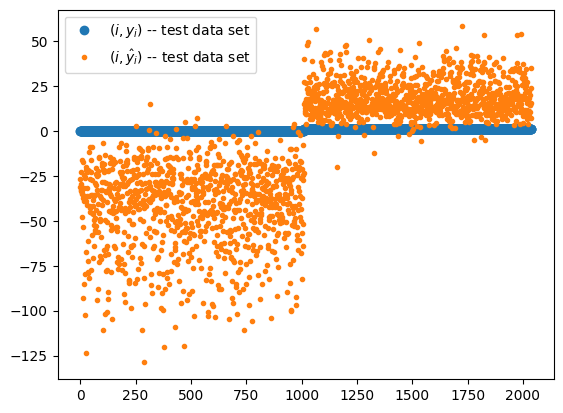

In [ ]:
plt.plot(yy,'o',label=r"$(i,y_i)$ -- test data set")
plt.plot(net(XX).data,'.',label=r"$(i,\hat{y}_i)$ -- test data set")  #이거 0 ~ 1 사이로 안눌렸지?
plt.legend()

In [ ]:
net(XX)

tensor([[-26.5073],
        [-31.4435],
        [-29.5559],
        ...,
        [ 15.6046],
        [ 23.7573],
        [  7.4338]], grad_fn=<AddmmBackward0>)

In [ ]:
(yy == (net(XX)>0.5)).float().mean() # test accuracy 잘 맞추노 ㅋㅋ

tensor(0.9902)

-   test 에서도 잘 맞춘다..

Cybenko, George. 1989. “Approximation by Superpositions of a Sigmoidal
Function.” *Mathematics of Control, Signals and Systems* 2 (4): 303–14.

In [ ]:
y = torch.tensor([0.0]*6131+[1.0]*6265).reshape(-1,1) #레이블 (참값)

In [ ]:
X_hw = X.reshape(-1,28*28).float()

In [ ]:
#과제
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(200):
    ## step1
    yhat = net(X_hw)
    ## step2
    loss = loss_fn(yhat,y)
    ## step3
    loss.backward()
    ## step4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
net(X_hw)

tensor([[-21.9406],
        [-44.6477],
        [-50.0297],
        ...,
        [ 27.3067],
        [ 26.2442],
        [ 20.8852]], grad_fn=<AddmmBackward0>)

In [ ]:
sig = torch.nn.Sigmoid()

In [ ]:
sig(net(X_hw).data)

tensor([[2.9601e-10],
        [4.0713e-20],
        [1.8723e-22],
        ...,
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]])

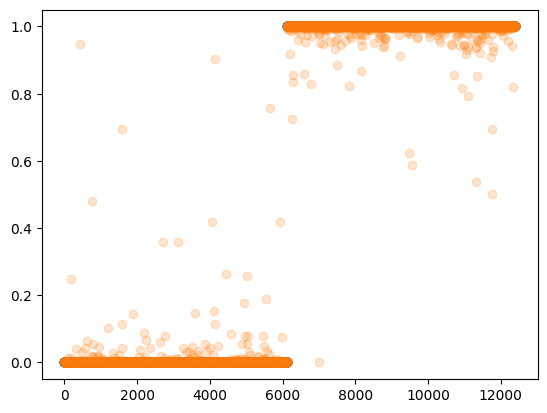

In [ ]:
plt.plot(y,'o',label=r"$(i,y_i)$ -- training data set")
plt.plot(sig(net(X_hw).data),'o',alpha = 0.2)

In [ ]:
(y == (((sig(net(X_hw))) > 0.5).float())).float().mean()

tensor(0.9996)